In [1]:
import os
import cv2
import math
import numpy as np
import random
from skimage import io
from sklearn.metrics import roc_auc_score
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import models
import matplotlib.pyplot as plt
from PIL import Image
from torch.utils.data import Dataset,DataLoader
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [ ]:
mix=['stad']
name='stad'

# model

In [2]:
class MODEL(nn.Module):
    def __init__(self,device):
        super(MODEL,self).__init__()
        self.res=models.resnet18(pretrained=True).to(device)
        self.layer=self.res._modules.get('avgpool')
        self.dense=nn.Linear(512,512).to(device)
        self.dropout=nn.Dropout(0.2).to(device)
        self.dense1=nn.Linear(512,256).to(device)
        self.dense2=nn.Linear(256,256).to(device)
        self.dense3=nn.Linear(256,128).to(device)
        self.dense4=nn.Linear(128,2).to(device)
    def forward(self,x):
        self.res.eval()
        embedding=torch.zeros([len(x),512]).to(device)
        def copy_data(m,i,o):
            embedding.copy_(o.data.reshape([o.data.size(0),o.data.size(1)]))
        h=self.layer.register_forward_hook(copy_data)
        self.res(x)
        h.remove()
        x=self.dense(embedding)
        x=F.relu(x)
        #x=self.dropout(x)
        x=self.dense1(x)
        x=F.relu(x)
        #x=self.dropout(x)
        x=self.dense2(x)
        x=F.relu(x)
        #x=self.dropout(x)
        x=self.dense3(x)
        x=F.relu(x)
        #x=self.dropout(x)
        x=self.dense4(x)
        output=x
        return output
transform=transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
def test(model,test_data):
    device=torch.device('cuda:0')
    loss_func=nn.CrossEntropyLoss().to(device)
    return val(model,test_data,device,loss_func,1)
def val(model,val_data,device,loss_func,test=0):
    val_data_loader=DataLoader(dataset=val_data,batch_size=5,shuffle=True,drop_last=False)   
    total_loss=0
    model.eval()
    count_all=0
    count_true=0
    p_count_all=0
    p_count_true=0 
    prob_all=[]
    label_all=[]
    for load in val_data_loader:
        img_names=load[0]
        labels=load[1]
        with torch.no_grad():
            images=torch.tensor([])
            for img_name in img_names:
                P=img_name.split('_')[-1][:-4]
                image=Image.open(os.path.join('s_cuts_'+P,img_name))
                image=transform(image)
                images=torch.cat((images,image.unsqueeze(0)),dim=0)
            images=images.float().to(device)
            labels=torch.tensor(labels).to(torch.int64).to(device)
            outputs=model(images)
            outputs_posi=torch.softmax(outputs,dim=0)
            for p in outputs_posi:
                prob_all.append(np.array(p.cpu()))
            labels_onehot=torch.zeros(len(outputs),2).to(device).scatter_(1,labels.unsqueeze(1),1)
            for p in labels_onehot:
                label_all.append(np.array(p.cpu()))
            c_out=torch.argmax(outputs,dim=1)
            count_all+=len(labels)
            p_count_all+=c_out.sum()
            count_true+=c_out.eq(labels).sum()
            p_count_true+=(c_out*labels).sum()
            loss=loss_func(outputs,labels)
            total_loss=loss+total_loss
        if test==1:
            print('outputs:',c_out,'labels:',labels)
    print('loss:\t',total_loss/len(val_data))
    accuracy=100*(count_true/count_all).item()
    if p_count_all==0:
        precision=0
    else:
        precision=100*(p_count_true/p_count_all).item()
    auc=roc_auc_score(label_all,prob_all)
    print('AUC:{:.4f}'.format(auc))
    print('accuracy:\t',str(accuracy)+'%')
    print('precision:\t',str(precision)+'%')
    return accuracy,precision,p_count_true,p_count_all,auc

def train(model,train_data,val_data,device,optimizer,loss_func,epochs):
    torch.cuda.empty_cache()
    x=[]
    y=[]
    for epoch in range(epochs):
        train_data_loader=DataLoader(dataset=train_data,batch_size=5,shuffle=True,drop_last=False)
        total_loss=0
        model.train()
        for load in train_data_loader:
            img_names=load[0]
            labels=load[1]
            images=torch.tensor([])
            for img_name in img_names:
                P=img_name.split('_')[-1][:-4]
                image=Image.open(os.path.join('s_cuts_'+P,img_name))
                image=transform(image)
                images=torch.cat((images,image.unsqueeze(0)),dim=0)
            images=images.float().to(device)
            labels=torch.tensor(labels).to(torch.int64).to(device)
            outputs=model(images)
            loss=loss_func(outputs,labels)
            total_loss=loss+total_loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        print(total_loss/len(train_data))
        torch.cuda.empty_cache()
        if epoch%1==0:
            print('epoch: ',epoch)
            accuracy,precision,p_count_true,p_count_all,auc=val(my_model,val_data,device,loss_func)
            x.append(epoch)
            y.append(auc)
            torch.save(my_model.state_dict(), './model/model_'+str(epoch)+ '.pkl')
    with open('./data_save/'+name+'_auc.txt','w') as f:
        for i in range(len(x)):
            f.write(str(x[i])+'\t'+str(y[i])+'\n')
    plt.plot(x,y)
    plt.savefig('./images/'+name+'_auc.png')
    plt.show()

# data

In [5]:
def get_labels(file_name,places,labels_lis):
    LIS=[]
    with open(file_name,'w') as f:
        for labels in labels_lis:
            T_LIS=[]
            for place in places:
                for each in os.listdir(place):
                    for label in labels:
                        if label[0]==each.split('_')[0]:
                            T_LIS.append((each,str(label[1])))
                            break
            LIS.append(T_LIS)
        if len(LIS[0])>len(LIS[1]):
            LIS[0]=LIS[0][:len(LIS[1])]
        else:
            LIS[1]=LIS[1][:len(LIS[0])]
        for e_LIS in LIS:
            for each in e_LIS:
                f.write(each[0]+'\t'+each[1]+'\n')

In [134]:
pos_labels=[]
neg_labels=[]
for N in mix:
    with open('data_labels/'+N+'_labels.txt') as f:
        lines=f.readlines()
        pos_lines=lines[:int(len(lines)/2)]
        neg_lines=lines[int(len(lines)/2):]
        pos_lines=list(np.random.choice(pos_lines,int(len(pos_lines)/len(mix)),replace=False))
        neg_lines=list(np.random.choice(neg_lines,int(len(neg_lines)/len(mix)),replace=False))
        #print(len(lines),len(pos_lines),len(neg_lines))
        for line in pos_lines:
            items=line.split()
            pos_labels.append((items[0],int(items[1])))
        for line in neg_lines:
            items=line.split()
            neg_labels.append((items[0],int(items[1])))
labels_lis=[pos_labels,neg_labels]

In [135]:
lis=[]
for N in mix:
    lis.append('s_cuts_'+N)
get_labels('data_labels/s_labels_'+name+'.txt',lis,labels_lis)

In [5]:
re_load=0
if re_load==1:
    s_labels=[]
    with open('data_labels/s_labels_'+name+'.txt') as f:
        lines=f.readlines()
        for line in lines:
            items=line.split()
            s_labels.append((items[0],float(items[1])))
    pos_s_labels=s_labels[:int(len(s_labels)/2)]
    neg_s_labels=s_labels[int(len(s_labels)/2):]
    a=int(len(pos_s_labels)*0.6)
    b=int(len(pos_s_labels)*0.2)
    c=len(pos_s_labels)-a-b
    a_n=int(len(neg_s_labels)*0.6)
    b_n=int(len(neg_s_labels)*0.2)
    c_n=len(neg_s_labels)-a_n-b_n
    pos_train_data,pos_val_data,pos_test_data=torch.utils.data.random_split(pos_s_labels,[a,b,c])
    neg_train_data,neg_val_data,neg_test_data=torch.utils.data.random_split(neg_s_labels,[a_n,b_n,c_n])
    train_data=pos_train_data+neg_train_data
    val_data=pos_val_data+neg_val_data
    test_data=pos_test_data+neg_test_data   
    torch.save((train_data,val_data,test_data),os.path.join('data_save','s_data_'+name+'.pkl'))
else:
    train_data,val_data,test_data=torch.load(os.path.join('data_save','s_data_'+name+'.pkl'))

# train

tensor(0.1270, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  0
loss:	 tensor(0.1239, device='cuda:0')
AUC:0.7215
accuracy:	 67.71301031112671%
precision:	 83.76068472862244%
tensor(0.1099, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  1
loss:	 tensor(0.1134, device='cuda:0')
AUC:0.7400
accuracy:	 69.28251385688782%
precision:	 69.90740895271301%
tensor(0.1040, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  2
loss:	 tensor(0.1238, device='cuda:0')
AUC:0.7333
accuracy:	 66.14350080490112%
precision:	 62.080538272857666%
tensor(0.0986, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  3
loss:	 tensor(0.1098, device='cuda:0')
AUC:0.7403
accuracy:	 72.6457417011261%
precision:	 76.16580128669739%
tensor(0.0916, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  4
loss:	 tensor(0.1096, device='cuda:0')
AUC:0.7686
accuracy:	 70.17937302589417%
precision:	 80.82191944122314%
tensor(0.0843, device='cuda:0', grad_fn=<DivBackward0>)
epoch:  5
loss:	 tensor(0.1074, device='cuda:0')
AUC:0.7701

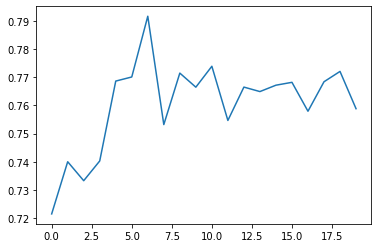

In [9]:
device=torch.device('cuda:0')
my_model=MODEL(device)
optimizer=optim.Adam(my_model.parameters(),lr=0.0001,betas=(0.5,0.999))
loss_func=nn.CrossEntropyLoss().to(device)
epochs=20
train(my_model,train_data,val_data,device,optimizer,loss_func,epochs)

In [11]:
torch.cuda.empty_cache()
device=torch.device('cuda:0')
test_model=MODEL(device)
test_model.load_state_dict(torch.load("./model/model_6.pkl"))
test(test_model,test_data)

outputs: tensor([1, 1, 0, 1, 1], device='cuda:0') labels: tensor([1, 0, 1, 1, 1], device='cuda:0')
outputs: tensor([1, 0, 1, 1, 0], device='cuda:0') labels: tensor([1, 0, 1, 1, 0], device='cuda:0')
outputs: tensor([0, 0, 1, 0, 1], device='cuda:0') labels: tensor([0, 1, 1, 0, 1], device='cuda:0')
outputs: tensor([0, 1, 1, 0, 1], device='cuda:0') labels: tensor([0, 0, 0, 1, 1], device='cuda:0')
outputs: tensor([0, 1, 0, 0, 1], device='cuda:0') labels: tensor([1, 1, 0, 0, 1], device='cuda:0')
outputs: tensor([1, 0, 1, 0, 0], device='cuda:0') labels: tensor([1, 0, 1, 1, 0], device='cuda:0')
outputs: tensor([0, 0, 0, 0, 1], device='cuda:0') labels: tensor([0, 0, 1, 0, 0], device='cuda:0')
outputs: tensor([1, 0, 1, 0, 1], device='cuda:0') labels: tensor([0, 0, 1, 0, 1], device='cuda:0')
outputs: tensor([0, 0, 1, 0, 0], device='cuda:0') labels: tensor([0, 0, 1, 0, 0], device='cuda:0')
outputs: tensor([1, 1, 1, 1, 1], device='cuda:0') labels: tensor([1, 0, 1, 1, 1], device='cuda:0')
outputs: t

outputs: tensor([1, 0, 0, 0, 0], device='cuda:0') labels: tensor([0, 0, 0, 1, 0], device='cuda:0')
outputs: tensor([0, 0, 1, 0, 1], device='cuda:0') labels: tensor([0, 1, 0, 0, 1], device='cuda:0')
outputs: tensor([0, 0, 0, 1, 1], device='cuda:0') labels: tensor([0, 0, 0, 0, 1], device='cuda:0')
outputs: tensor([1, 0, 0, 0, 0], device='cuda:0') labels: tensor([0, 1, 0, 1, 0], device='cuda:0')
outputs: tensor([1], device='cuda:0') labels: tensor([1], device='cuda:0')
loss:	 tensor(0.1251, device='cuda:0')
AUC:0.7862
accuracy:	 74.21525120735168%
precision:	 74.32432174682617%


(74.21525120735168,
 74.32432174682617,
 tensor(165, device='cuda:0'),
 tensor(222, device='cuda:0'),
 0.7861710470751473)

# predict whole image

# model

In [5]:
class MODEL_whole(nn.Module):
    def __init__(self,device):
        super(MODEL_whole,self).__init__()
        self.res=models.resnet18(pretrained=True).to(device)
        self.layer=self.res._modules.get('avgpool')
        self.dense=nn.Linear(512,512).to(device)
        self.dropout=nn.Dropout(0.2).to(device)
        self.dense1=nn.Linear(512,256).to(device)
        self.dense2=nn.Linear(256,256).to(device)
        self.dense3=nn.Linear(256,128).to(device)
        self.dense4=nn.Linear(128,2).to(device)
    def forward(self,x):
        self.res.eval()
        embedding=torch.zeros([len(x),512]).to(device)
        def copy_data(m,i,o):
            embedding.copy_(o.data.reshape([o.data.size(0),o.data.size(1)]))
        h=self.layer.register_forward_hook(copy_data)
        self.res(x)
        h.remove()
        x=self.dense(embedding)
        x=F.relu(x)
        #x=self.dropout(x)
        x=self.dense1(x)
        x=F.relu(x)
        #x=self.dropout(x)
        x=self.dense2(x)
        x=F.relu(x)
        #x=self.dropout(x)
        x=self.dense3(x)
        x=F.relu(x)
        #x=self.dropout(x)
        x=self.dense4(x)
        output=x.mean(dim=0)
        #output=x.max(dim=0).values
        return output
transform=transforms.Compose([
    transforms.Resize([224, 224]),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [6]:
def test_whole(model,test_data,thr=0.5):
    device=torch.device('cuda:0')
    loss_func=nn.CrossEntropyLoss().to(device)
    return val_whole(model,test_data,device,loss_func,1,thr)
def val_whole(model,val_data,device,loss_func,test=0,thr=0.5):
    val_data_loader=DataLoader(dataset=val_data,batch_size=1,shuffle=True,drop_last=False)   
    total_loss=0
    model.eval()
    count_all=0
    count_true=0
    p_count_all=0
    p_count_true=0
    for load in val_data_loader:
        img_names=load[0]
        label=load[1][0]
        with torch.no_grad():
            images=torch.tensor([])
            for im in img_names:
                img_name=im[0]
                P=img_name.split('_')[-1][:-4]
                image=Image.open(os.path.join('s_cuts_'+P,img_name))
                image=transform(image)
                images=torch.cat((images,image.unsqueeze(0)),dim=0)
            images=images.float().to(device)
            label=torch.tensor(label).to(torch.int64).to(device)
            outputs=model(images)
            outputs_posi=torch.softmax(outputs,dim=0)
            if thr!=0.5:
                if outputs_posi[1]>thr:
                    c_out=torch.tensor(1)
                else:
                    c_out=torch.tensor(0)
            else:
                c_out=torch.argmax(outputs)
            count_all+=1
            p_count_all+=c_out
            count_true+=c_out.eq(label)
            p_count_true+=(c_out*label)
            loss=loss_func(outputs,label)
            total_loss=loss+total_loss
        if test==1:
            print('outputs:',c_out.item(),'label:',label.item())
    print('loss:\t',total_loss/len(val_data))
    accuracy=100*(count_true/count_all).item()
    if p_count_all==0:
        precision=0
    else:
        precision=100*(p_count_true/p_count_all).item()
    print(count_true.item(),count_all,p_count_true.item(),p_count_all.item())
    print('accuracy:\t',str(accuracy)+'%')
    print('precision:\t',str(precision)+'%')
    return accuracy,precision,p_count_true,p_count_all

# data_whole

In [7]:
def get_labels_whole(file_name,places,labels_lis):
    counts=[]
    with open(file_name,'w') as f:
        for labels in labels_lis:
            count=0
            for place in places:
                c_label=0
                c_label2=0
                keep=[]
                DIR=os.listdir(place)
                for each in os.listdir(place):
                    if each.split('_')[0]!=c_label or (each.split('_')[0]==c_label and each==DIR[-1]):
                        if len(keep)!=0:
                            count+=1
                            if count==51:
                                break
                            f.write(c_label+'\t')
                            for each2 in keep:
                                f.write(each2+'\t')
                            f.write(str(c_label2)+'\n')
                            keep=[]
                        L=0
                        for label in labels:
                            if label[0]==each.split('_')[0]:
                                L=1
                                c_label=label[0]
                                c_label2=label[1]
                                break
                        if L==0:
                            continue
                    keep.append(each)
                if count==51:
                    break
            counts.append(count-1)
    return counts

In [8]:
pos_labels=[]
neg_labels=[]
for N in mix:
    with open('data_labels/'+N+'_labels.txt') as f:
        lines=f.readlines()
        pos_lines=lines[:int(len(lines)/2)]
        neg_lines=lines[int(len(lines)/2):]
        pos_lines=list(np.random.choice(pos_lines,int(len(pos_lines)/len(mix)),replace=False))
        neg_lines=list(np.random.choice(neg_lines,int(len(neg_lines)/len(mix)),replace=False))
        print(len(lines),len(pos_lines),len(neg_lines))
        for line in pos_lines:
            items=line.split()
            pos_labels.append((items[0],int(items[1])))
        for line in neg_lines:
            items=line.split()
            neg_labels.append((items[0],int(items[1])))
labels=[pos_labels,neg_labels]

286 143 143


In [176]:
lis=[]
for N in mix:
    lis.append('s_cuts_'+N)
Ls=get_labels_whole('data_labels/s_whole_labels_'+name+'.txt',lis,labels)

In [9]:
re_load=0
if re_load==1:
    s_labels=[]
    with open('data_labels/s_whole_labels_'+name+'.txt') as f:
        lines=f.readlines()
        for line in lines:
            items=line.split()
            s_labels.append((items[1:-1],float(items[-1])))
    pos_s_labels=s_labels[:Ls[0]]
    neg_s_labels=s_labels[Ls[0]:]
    a=int(len(pos_s_labels)*0.6)
    b=int(len(pos_s_labels)*0.2)
    c=len(pos_s_labels)-a-b
    a_n=int(len(neg_s_labels)*0.6)
    b_n=int(len(neg_s_labels)*0.2)
    c_n=len(neg_s_labels)-a_n-b_n
    pos_train_data,pos_val_data,pos_test_data=torch.utils.data.random_split(pos_s_labels,[a,b,c])
    neg_train_data,neg_val_data,neg_test_data=torch.utils.data.random_split(neg_s_labels,[a_n,b_n,c_n])
    train_data=pos_train_data+neg_train_data
    val_data=pos_val_data+neg_val_data
    test_data=pos_test_data+neg_test_data  
    torch.save((train_data,val_data,test_data),os.path.join('data_save','s_whole_data_'+name+'.pkl'))
else:
    train_data,val_data,test_data=torch.load(os.path.join('data_save','s_whole_data_'+name+'.pkl'))

# test_whole

In [180]:
torch.cuda.empty_cache()
device=torch.device('cuda:0')
test_model=MODEL_whole(device)
test_model.load_state_dict(torch.load("./model/model_6.pkl"))
test_whole(test_model,test_data)

outputs: 0 label: 1
outputs: 0 label: 0
outputs: 0 label: 0
outputs: 0 label: 0
outputs: 1 label: 1
outputs: 0 label: 0
outputs: 0 label: 1
outputs: 0 label: 0
outputs: 1 label: 1
outputs: 1 label: 1
outputs: 0 label: 0
outputs: 0 label: 1
outputs: 0 label: 1
outputs: 0 label: 1
outputs: 1 label: 1
outputs: 0 label: 0
outputs: 0 label: 0
outputs: 0 label: 0
outputs: 0 label: 0
outputs: 1 label: 1
loss:	 tensor(0.4080, device='cuda:0')
15 20 5 5
accuracy:	 75.0%
precision:	 100.0%


(75.0, 100.0, tensor(5, device='cuda:0'), tensor(5, device='cuda:0'))

# EXTRAS

# real val

In [182]:
v_dict={}
device=torch.device('cuda:0')
test_model=MODEL_whole(device)
test_model.load_state_dict(torch.load("./model/model_X.pkl"))
with open('data_labels\s_whole_labels_stad_use.txt') as f:
    lines=f.readlines()
    for line in lines:
        items=line.split()
        images=torch.tensor([])
        for img_name in items[1:]:
            P=img_name.split('_')[-1][:-4]
            image=Image.open(os.path.join('s_cuts_'+P,img_name))
            image=transform(image)
            images=torch.cat((images,image.unsqueeze(0)),dim=0)
        images=images.float().to(device)
        outputs=test_model(images)
        outputs_posi=torch.softmax(outputs,dim=0)
        v_dict[items[0]]=outputs_posi[1]

In [183]:
v_dict

{'304189.3.tif': tensor(0.4395, device='cuda:0', grad_fn=<SelectBackward0>),
 '304189.tif': tensor(0.2326, device='cuda:0', grad_fn=<SelectBackward0>),
 '304200.3.tif': tensor(0.7559, device='cuda:0', grad_fn=<SelectBackward0>),
 '304200.tif': tensor(0.7476, device='cuda:0', grad_fn=<SelectBackward0>),
 '304205.3.tif': tensor(0.6753, device='cuda:0', grad_fn=<SelectBackward0>),
 '304205.tif': tensor(0.6774, device='cuda:0', grad_fn=<SelectBackward0>),
 '304449.3.tif': tensor(0.2123, device='cuda:0', grad_fn=<SelectBackward0>),
 '304449.tif': tensor(0.1503, device='cuda:0', grad_fn=<SelectBackward0>),
 '304486.3.tif': tensor(0.6251, device='cuda:0', grad_fn=<SelectBackward0>),
 '304486.tif': tensor(0.2208, device='cuda:0', grad_fn=<SelectBackward0>),
 '304745.3.tif': tensor(0.1294, device='cuda:0', grad_fn=<SelectBackward0>),
 '304745.tif': tensor(0.1122, device='cuda:0', grad_fn=<SelectBackward0>),
 '304944.3.tif': tensor(0.2262, device='cuda:0', grad_fn=<SelectBackward0>),
 '304944.ti

In [204]:
results=[[],[],[],[],[]]
for key in v_dict.keys():
    value=v_dict[key]
    if value<0.3:
        results[0].append(key)
    if value>0.8:
        results[1].append(key)
    if value>0.7:
        results[2].append(key)
    if value>0.6:
        results[3].append(key)

In [205]:
print('those samples has possibility of being infected below 0.3:')
for each in results[0]:
    print(each)
print('those samples has possibility of being infected above 0.8:')
for each in results[1]:
    print(each)
print('those samples has possibility of being infected above 0.7:')
for each in results[2]:
    print(each)
print('those samples has possibility of being infected above 0.6:')
for each in results[3]:
    print(each)

those samples has possibility of being infected below 0.3:
304189.tif
304449.3.tif
304449.tif
304486.tif
304745.3.tif
304745.tif
304944.3.tif
304944.tif
304950.3.tif
304950.tif
305221.tif
305343.tif
305411.3.tif
305411.tif
305553.tif
307746.3.tif
307746.tif
307793.tif
308151.3.tif
308151.tif
308360.tif
308461.tif
those samples has possibility of being infected above 0.8:
308617.3.tif
308749.3.tif
308749.tif
those samples has possibility of being infected above 0.7:
304200.3.tif
304200.tif
308500.3.tif
308617.3.tif
308749.3.tif
308749.tif
those samples has possibility of being infected above 0.6:
304200.3.tif
304200.tif
304205.3.tif
304205.tif
304486.3.tif
307793.3.tif
308500.3.tif
308617.3.tif
308749.3.tif
308749.tif


# show with colored image

In [32]:
device=torch.device('cuda:0')
test_model=MODEL(device)
test_model.load_state_dict(torch.load("./model/model_X.pkl"))
with open('slide_weights.txt','w') as f:
    for each in os.listdir('s_cuts_staduse'):
        if each[-4:]=='.png':
            image=Image.open(os.path.join('s_cuts_staduse',each))
            image=transform(image).unsqueeze(0)
            image=image.float().to(device)
            output=test_model(image)
            output_posi=torch.softmax(output,dim=1)
            f.write(each+'\t'+str(output_posi[0][1].item())+'\n')

In [10]:
v_dic={}
with open('slide_weights.txt') as f:
    lines=f.readlines()
    for line in lines:
        items=line.split()
        v_dic[items[0]]=items[1]
for each in os.listdir('stad_use'):
    if each[-4:]=='.tif':
        image=Image.open(os.path.join('stad_use',each))
        crop_box=(0,0,math.floor(image.size[0]/512)*512,math.floor(image.size[1]/512)*512)
        image=image.crop(crop_box)
        image2=Image.new('RGB',image.size)
        for i in range(math.floor(image.size[1]/512)):
            for j in range(math.floor(image.size[0]/512)):
                if each+'_'+str(i)+'_'+str(j)+'_staduse.png' in v_dic.keys():
                    score=float(v_dic[each+'_'+str(i)+'_'+str(j)+'_staduse.png'])
                    score=score*score
                else:
                    score=0
                image2.paste((0,0,int(255*score)),(j*512,i*512,(j+1)*512,(i+1)*512))
        image=np.array(image)
        image2=np.array(image2)
        image3=cv2.addWeighted(image,0.3,image2,0.7,0)
        image3=Image.fromarray(image3)
        image3.save('colored/'+each+'_colored.png')